## Abstract

In this notebook, we create hexagons for a network file with the format .xml.gz. 

The steps are as follows:  
1. Load the network.xml.gz file
2. Create a gdf out of it.
3. Implement the hexagons on the gdf level, adding another column "hexagon", numbered 1 - n for a city. 
4. Visualize the hexagons for different hexagon sizes.
5. Save the gdfs for hexagons with different sizes. 

### Import Section

In [3]:
import network_io as nio
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import shapely.geometry as sgeo
import network_io as nio
import numpy as np

### Filepaths:

In [1]:
matsim_output_file_path = r"C:\Users\nktba\city_data\augsburg_network.xml.gz" #the filepath to the network file in .xml.gz format
administrative_boundary_json_path = r"C:\Users\nktba\city_data\Augsburg.json" #the filepath to the administrative boundary file in .geojson or json format  

### Parsing the Network File and Creating the Network Geodataframe

In [4]:
nodes_dict = nio.parse_nodes(matsim_output_file_path) #list of nodes in the network file    
df_edges = nio.parse_edges(matsim_output_file_path, nodes_dict) #list of edges in the network file
gdf_edges = gpd.GeoDataFrame(df_edges, geometry='geometry', crs='EPSG:25832') #geodataframe of edges
if gdf_edges.crs != "EPSG:25832": #if the crs of the edges is not EPSG:25832, convert it to EPSG:25832 **********VERY IMPORTANT**********
    gdf_edges = gdf_edges.to_crs(epsg=25832)

### Reading the Administrative Boundary File

In [5]:
# Read the original GeoJSON file (assumed to be in EPSG:25832)
gdf = gpd.read_file(administrative_boundary_json_path)

In [6]:
gdf.geom_type == "MultiPolygon" #check if the geometry type of the districts file is MultiPolygon

0    True
1    True
dtype: bool

### (Optional) Only run if the cell output of above line is TRUE
If the administrative boundary file has geometry type of Multiploygon, convert it to Type Polygon

In [7]:
def multipolygon_to_polygon(geom):
    '''
    This function converts a MultiPolygon to a Polygon with the largest area.
    '''
    return max(geom.geoms, key=lambda p: p.area)
    

# Convert any MultiPolygon geometries to Polygon
gdf["geometry"] = gdf["geometry"].apply(multipolygon_to_polygon)

### Modifying the District Geodataframe to required structure


In [8]:
gdf["surface"] = gdf.geometry.area
gdf["perimetre"] = gdf.geometry.length
gdf["zone_id"] = range(1, len(gdf)+1) #zone
# Keep only the desired columns
districts_gdf = gdf[["zone_id", "surface", "perimetre", "geometry"]]
# Ensure the data is in the correct CRS (EPSG:25832) **********VERY IMPORTANT**********
if districts_gdf.crs != "EPSG:25832": #should match with the CRS of the Network Geodataframe
    districts_gdf = districts_gdf.to_crs(epsg=25832)

In [9]:
districts_gdf

,zone_id,surface,perimetre,geometry
0,1,1.464123e+08,86288.620619,"POLYGON ((640213.187 5368567.674, 640233.279 5..."
1,2,1.071100e+09,308969.771652,"POLYGON ((638789.105 5388806.692, 638803.938 5..."


In [10]:
districts_gdf =districts_gdf[districts_gdf['zone_id']==1]

In [11]:
districts_gdf

,zone_id,surface,perimetre,geometry
0,1,1.464123e+08,86288.620619,"POLYGON ((640213.187 5368567.674, 640233.279 5..."


### Assigning District IDs to each edges of the Network Geodataframe
Here we spatially join the Network Geodataframe and the District Geodataframe to find districts overlapping each edge

In [12]:
gdf_edges_with_districts = gpd.sjoin(gdf_edges, districts_gdf, how='left', predicate='intersects') #left join to ensure all edges are included

# some edges may be overlapping multiple districts, so we need to aggregate the district IDs for each edge
gdf_edges_with_districts = gdf_edges_with_districts.groupby('id').agg({
    'from': 'first',
    'to': 'first',
    'length': 'first',
    'freespeed': 'first',
    'capacity': 'first',
    'permlanes': 'first',
    'oneway': 'first',
    'modes': 'first',
    'geometry': 'first',
    'zone_id': lambda x: list(x.dropna()) #aggregate the district IDs for each edge and drop the NA values
}).reset_index()

# Convert freespeed and capacity to numeric values
gdf_edges_with_districts['freespeed'] = pd.to_numeric(gdf_edges_with_districts['freespeed'], errors='coerce')
gdf_edges_with_districts['capacity'] = pd.to_numeric(gdf_edges_with_districts['capacity'], errors='coerce')

### Creating a Combined Geodataframe for Network Edges with District IDS

In [13]:
# Create a GeoDataFrame with the results
gdf_edges_with_districts = gpd.GeoDataFrame(gdf_edges_with_districts, geometry='geometry', crs='EPSG:25832')

### Checkpoint 1
To check that the created Geodataframe contains the unique Districts only

In [14]:
unique_values = set(item for sublist in gdf_edges_with_districts['zone_id'] for item in sublist)
print(unique_values)

{1.0}


### A function to generate Hexagonal Grid

In [15]:
def generate_hexagon_grid_for_polygon(polygon, hexagon_size, projection='EPSG:25832'):
    """
    Generates a hexagonal grid that fits within a given polygon.

    Parameters:
        polygon (shapely.geometry.Polygon): The polygon to clip the grid to.
        hexagon_size (float): The distance from the hexagon's center to any vertex.
        projection (str): The coordinate reference system for the polygon and grid.
    
    Returns:
        GeoDataFrame: A GeoDataFrame containing hexagons (as polygons) clipped to the input polygon,
                      each with a unique hexagon grid_id.
    """
    # Create a GeoDataFrame from the input polygon using the given projection.
    poly_gdf = gpd.GeoDataFrame({'geometry': [polygon]}, crs=projection)
    
    # Obtain the bounding box of the polygon.
    xmin, ymin, xmax, ymax = poly_gdf.total_bounds

    # Compute the vertical scaling factor using sin(60°) (~0.866).
    # This factor is used to correctly space the hexagon vertices vertically.
    a = np.sin(np.pi / 3) 

    # Define the x positions (columns) for hexagon grid centers.
    # Here, the horizontal spacing between potential hexagon positions is 3 * hexagon_size.
    cols = np.arange(np.floor(xmin), np.ceil(xmax), 3 * hexagon_size)
    
    # Define the y positions (rows) for hexagon grid centers.
    # The y positions are scaled by the factor 'a' to account for the vertical distance between rows.
    rows = np.arange(np.floor(ymin) / a, np.ceil(ymax) / a, hexagon_size)

    # Generate hexagon geometries for each grid position.
    hexagons = []
    for x in cols:
        for i, y in enumerate(rows):
            # Offset every other row horizontally to create a staggered hexagon grid.
            if i % 2 == 0:
                x0 = x
            else:
                x0 = x + 1.5 * hexagon_size

            # Create a hexagon by specifying its six vertices.
            # The vertices are calculated relative to (x0, y) and scaled vertically by 'a'.
            hexagon = sgeo.Polygon([
                (x0, y * a),
                (x0 + hexagon_size, y * a),
                (x0 + 1.5 * hexagon_size, (y + hexagon_size) * a),
                (x0 + hexagon_size, (y + 2 * hexagon_size) * a),
                (x0, (y + 2 * hexagon_size) * a),
                (x0 - 0.5 * hexagon_size, (y + hexagon_size) * a),
            ])
            hexagons.append(hexagon)
    
    # Convert the list of hexagons into a GeoDataFrame with the specified projection.
    grid = gpd.GeoDataFrame({'geometry': hexagons}, crs=projection)
    
    # Clip the hexagon grid to the input polygon so that only hexagons (or portions thereof)
    # that fall within the polygon are retained.
    grid_clipped = gpd.clip(grid, poly_gdf)
    
    # Reset the index and assign a unique grid_id to each hexagon.
    grid_clipped = grid_clipped.reset_index(drop=True)
    grid_clipped['grid_id'] = grid_clipped.index
    
    return grid_clipped

### Assigning Unique Hexagon IDs to each edges of the Combined Geodataframe (Network Edges with District IDS)
In this step, we perform a spatial join between the hexagon grid GeoDataFrame and the Combined Geodataframe (Network Edges with District IDS). This join identifies which hexagons overlap each network edge and also flags hexagons that crosses multiple districts (these will later be highlighted in red).

**Important**:
Here we define the required size of the Hexagons as per our requirement

In [16]:
# First, get the outer boundary of the entire region
region_boundary = districts_gdf.union_all()

# Create a single continuous hexagon grid for the entire region
hexagon_size = 1500  # Size in meters for EPSG:25832 and in degrees for EPSG:4326 **********VERY IMPORTANT********** 
hexagon_grid_all = generate_hexagon_grid_for_polygon(region_boundary, hexagon_size, projection='EPSG:25832')
# Add district information to each hexagon
def get_intersecting_districts(hex_geom):
    """
    This function takes a hexagon geometry and returns a list of district IDs that intersect with the hexagon.
    """
    intersecting_districts = []
    for idx, row in districts_gdf.iterrows():
        if hex_geom.intersects(row['geometry']):
            district_id = row.get('district_name', idx+1)
            intersecting_districts.append(district_id)
    return intersecting_districts

hexagon_grid_all['districts'] = hexagon_grid_all['geometry'].apply(get_intersecting_districts)
print(f"Total number of hexagons created: {len(hexagon_grid_all)}")
print(f"Number of hexagons in multiple districts: {len(hexagon_grid_all[hexagon_grid_all['districts'].apply(lambda x: len(x) >= 2)])}")

# Spatial join to assign each edge the hexagon(s) it falls into
gdf_edges_with_hex = gpd.sjoin(gdf_edges_with_districts, hexagon_grid_all[['geometry', 'districts', 'grid_id']], 
                              how='left', predicate='intersects')

# Group by edge 'id' and aggregate the hexagon IDs into a list
gdf_edges_with_hex = gdf_edges_with_hex.groupby('id').agg({
    'from': 'first',
    'to': 'first',
    'length': 'first',
    'freespeed': 'first',
    'capacity': 'first',
    'permlanes': 'first',
    'oneway': 'first',
    'modes': 'first',
    'geometry': 'first',
    'grid_id': lambda x: list(x.dropna()), #aggregate the hexagon IDs for each edge and drop the NA values
    'districts': lambda x: list(set([d for dist_list in x.dropna() for d in dist_list if isinstance(dist_list, list)]))  # Aggregate unique districts
}).reset_index()

# Rename the aggregated column
gdf_edges_with_hex.rename(columns={'grid_id': 'hexagon'}, inplace=True)
gdf_edges_with_hex.rename(columns={'districts': 'zones'}, inplace=True)

# Hexagon Statistics
print("\nEdge Statistics:")
print(f"Total number of edges: {len(gdf_edges_with_hex)}")
print(f"Number of edges in multiple hexagons: {len(gdf_edges_with_hex[gdf_edges_with_hex['hexagon'].apply(lambda x: len(x) >= 2)])}")
print(f"Number of edges in multiple districts: {len(gdf_edges_with_hex[gdf_edges_with_hex['zones'].apply(lambda x: len(x) >= 2)])}")


Total number of hexagons created: 43
Number of hexagons in multiple districts: 0

Edge Statistics:
Total number of edges: 22085
Number of edges in multiple hexagons: 786
Number of edges in multiple districts: 0


### Checkpoint 2
1. There are no Nan Values in the unique hexagon ids
2. Number of hexagon containing edges are less than or equal to the total number of hexagons created but NEVER more than that.

In [17]:
unique_values = set(item for sublist in gdf_edges_with_hex['hexagon'] for item in sublist)
print(unique_values)
print('Number of Hexagons containing edges: ', len (unique_values))
print('Total number of Hexagons created: ', len(hexagon_grid_all))

{2.0, 3.0, 5.0, 6.0, 11.0, 13.0, 14.0, 15.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 40.0}
Number of Hexagons containing edges:  30
Total number of Hexagons created:  43


### Section: Plotting WITHOUT District Boundary Layer

C:\Users\nktba\AppData\Local\Temp\ipykernel_2516\3418649324.py:14: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  hexagon_grid_all[hexagon_grid_all['districts'].apply(lambda x: len(x) >= 2)].plot(


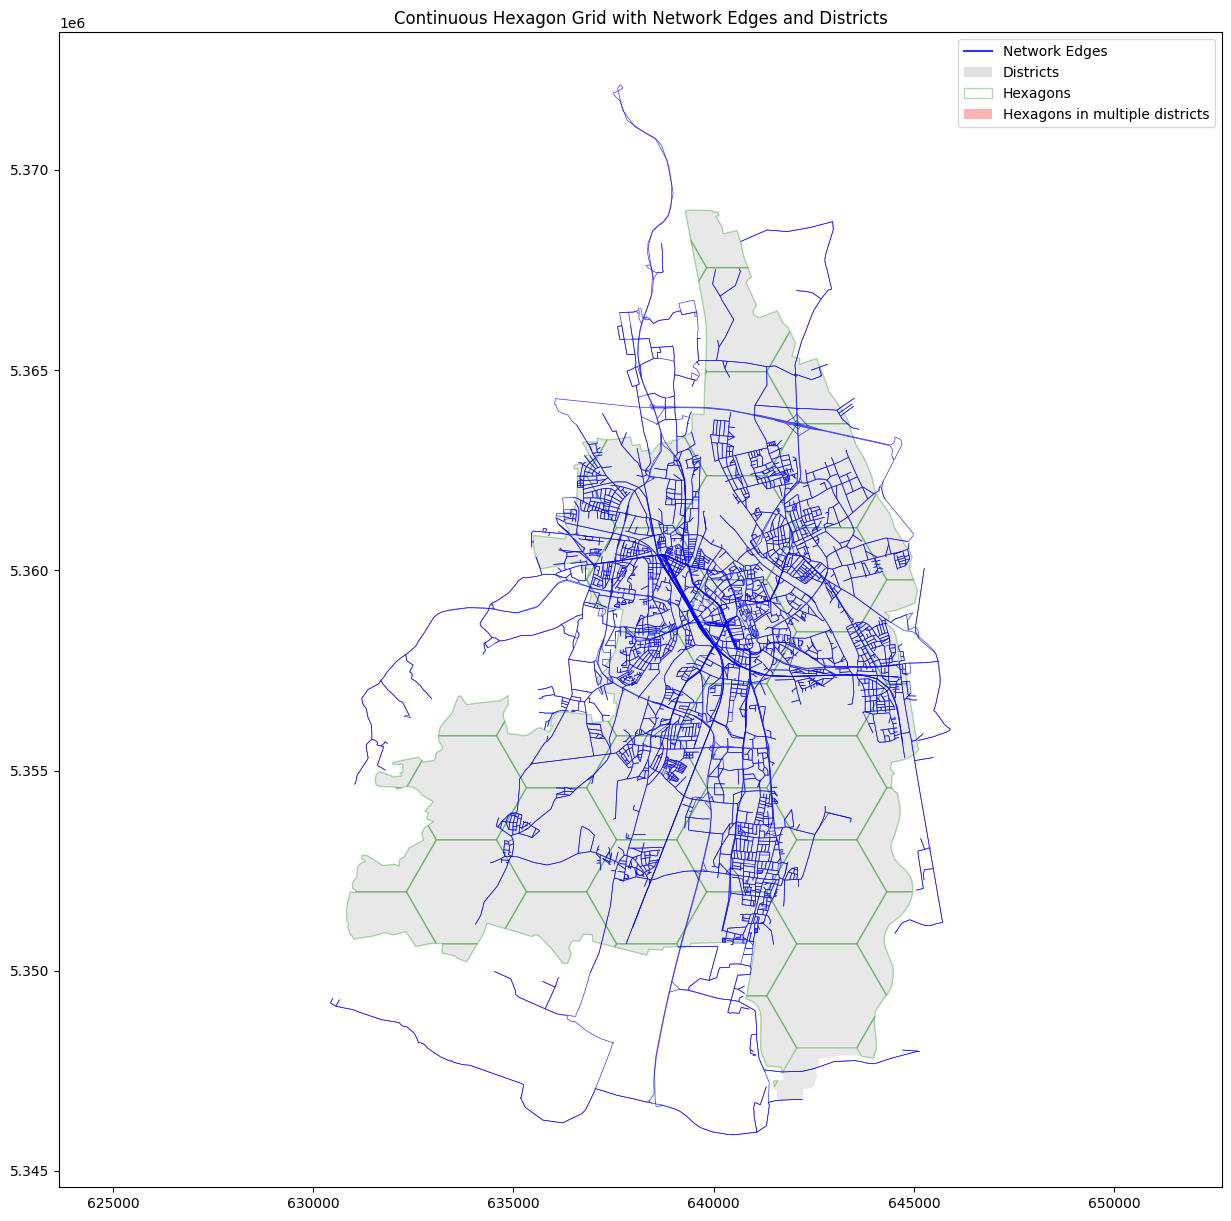

In [18]:
#Adjust accordingly
fig, ax = plt.subplots(figsize=(15, 15))

# Plot edges first (in the background)
gdf_edges_with_districts.plot(ax=ax, color='blue', alpha=0.8, linewidth=0.5, label='Network Edges')

# Plot districts
districts_gdf.plot(ax=ax, color='lightgray', alpha=0.5, label='Zones')

# Plot all hexagons
hexagon_grid_all.plot(ax=ax, color='none', edgecolor='green', alpha=0.3, label='Hexagons')

# Highlight hexagons which contain edges crossing multiple districts
hexagon_grid_all[hexagon_grid_all['districts'].apply(lambda x: len(x) >= 2)].plot(
    ax=ax, color='red', alpha=0.3, label='Hexagons in multiple districts'
)

# Add legend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [
    Line2D([0], [0], color='blue', alpha=0.8, label='Network Edges'),
    Patch(facecolor='lightgray', alpha=0.7, label='Districts'),
    Patch(facecolor='none', edgecolor='green', alpha=0.3, label='Hexagons'),
    Patch(facecolor='red', alpha=0.3, label='Hexagons in multiple districts')
]

ax.legend(handles=legend_elements)
plt.title('Continuous Hexagon Grid with Network Edges and Districts')
plt.axis('equal')
plt.show()

### Section: Plotting WITH District Boundary Layer

C:\Users\nktba\AppData\Local\Temp\ipykernel_2516\3333273405.py:20: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  hexagon_grid_all[hexagon_grid_all['districts'].apply(lambda x: len(x) >= 2)].plot(


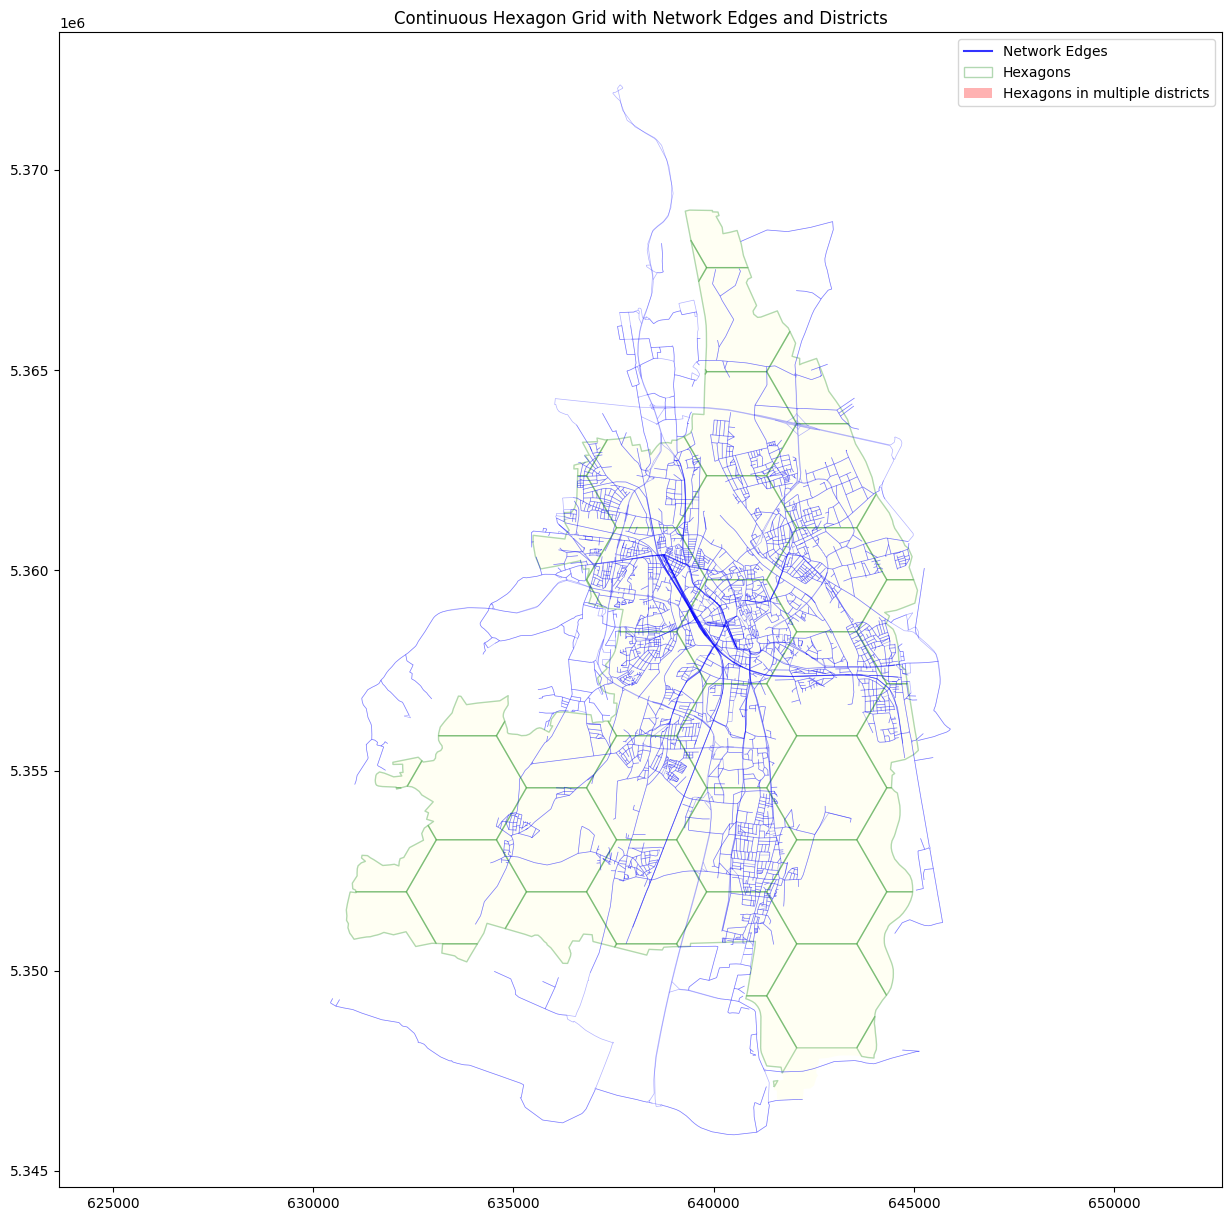

In [19]:
#Adjust accordingly
fig, ax = plt.subplots(figsize=(15, 15))

# Plot edges first (in the background)
gdf_edges_with_districts.plot(ax=ax, color='blue', alpha=0.3, linewidth=0.5, label='Network Edges')

# Plot districts
districts_gdf.plot(ax=ax, 
                  column='zone_id',  # Color by c_ar values
                  cmap='YlGnBu',  # Color scheme
                  alpha=0.3,       # Transparency
                  legend=False,     # Show legend
                  legend_kwds={'label': 'District Area (m²)'},  # Legend label
                  label='Districts')

# Plot all hexagons
hexagon_grid_all.plot(ax=ax, color='none', edgecolor='green', alpha=0.3, label='Hexagons')

# Highlight hexagons which contain edges crossing multiple districts
hexagon_grid_all[hexagon_grid_all['districts'].apply(lambda x: len(x) >= 2)].plot(
    ax=ax, color='red', alpha=0.3, label='Hexagons in multiple districts'
)

# Add legend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [
    Line2D([0], [0], color='blue', alpha=0.8, label='Network Edges'),
    #Patch(facecolor='lightgray', alpha=0.7, label='Districts'),
    Patch(facecolor='none', edgecolor='green', alpha=0.3, label='Hexagons'),
    Patch(facecolor='red', alpha=0.3, label='Hexagons in multiple districts')
]

ax.legend(handles=legend_elements)
plt.title('Continuous Hexagon Grid with Network Edges and Districts')
plt.axis('equal')
plt.show()

In [22]:
gdf_edges_with_hex

,id,from,to,length,freespeed,capacity,permlanes,oneway,modes,geometry,hexagon,zones
0,1000363,26356756,26356758,85.23944728091674,8.333333,600.0,1.0,1,"car,car_passenger","LINESTRING (643784.577 5356850.917, 643699.676...",[14.0],[1]
1,1000364,26356758,26356756,85.23944728091674,8.333333,600.0,1.0,1,"car,car_passenger","LINESTRING (643699.676 5356843.396, 643784.577...",[14.0],[1]
2,1001475,284592053,300117819,8.333333333333334,8.333333,600.0,1.0,1,"car,car_passenger","LINESTRING (641379.213 5357508.895, 641373.004...",[24.0],[1]
3,1001476,300117819,284592053,8.333333333333334,8.333333,600.0,1.0,1,"car,car_passenger","LINESTRING (641373.004 5357514.123, 641379.213...",[24.0],[1]
4,1001477,284592071,284592083,98.40619993369137,8.333333,600.0,1.0,1,"car,car_passenger","LINESTRING (641328.79 5357561.478, 641248.704 ...",[24.0],[1]
...,...,...,...,...,...,...,...,...,...,...,...,...
22080,pt_94915_pt_445964,pt_94915,pt_445964,376.29588583964056,7.000000,9999.0,1.0,1,"artificial,tram","LINESTRING (640818.555 5356769.224, 640905.323...",[22.0],[1]
22081,pt_95558,pt_95558,pt_95558,20.0,20.000000,9999.0,1.0,1,"artificial,stopFacilityLink,tram","LINESTRING (641383.087 5355169.087, 641383.087...",[22.0],[1]
22082,pt_95558_pt_562266,pt_95558,pt_562266,757.4048250304261,7.000000,9999.0,1.0,1,"artificial,tram","LINESTRING (641383.087 5355169.087, 641429.264...","[21.0, 22.0]",[1]
22083,pt_95699,pt_95699,pt_95699,20.0,20.000000,9999.0,1.0,1,"artificial,stopFacilityLink,tram","LINESTRING (640902.112 5357479.841, 640902.112...",[24.0],[1]


In [23]:
hexagon_grid_all

,geometry,grid_id,districts
0,"POLYGON ((634100.177 5350672.114, 633929.951 5...",0,[1]
1,"POLYGON ((632325 5351971.152, 633069.673 53506...",1,[1]
2,"POLYGON ((635325 5351971.152, 636825 5351971.1...",2,[1]
3,"POLYGON ((633231.217 5350672.114, 633231.565 5...",3,[1]
4,"MULTIPOLYGON (((633075 5353270.191, 632325 535...",4,[1]
5,"POLYGON ((634575 5353270.191, 635325 5354569.2...",5,[1]
6,"POLYGON ((634575 5355868.267, 635325 5354569.2...",6,[1]
7,"POLYGON ((632072.96 5354569.229, 632069.053 53...",7,[1]
8,"POLYGON ((643575 5348074.038, 644025.671 53488...",8,[1]
9,"POLYGON ((643575 5348074.038, 642075 5348074.0...",9,[1]


### Saving File